In [1]:

import os
import sys
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchinfo import summary
import os
import sys
import matplotlib.pyplot as plt
import argparse
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split


In [2]:
import TRACK_POS, TRACK_SAL
import position_dataset

In [3]:
from Utils import cartesian_to_eulerian, eulerian_to_cartesian, get_max_sal_pos,load_dict_from_csv,all_metrics, store_list_as_csv, MetricOrthLoss, OrthDist
from data_utils import fan_nossdav_split, PositionDataset
from DatasetHelper import read_sampled_positions_for_trace, load_saliency, load_true_saliency, get_video_ids, get_user_ids, get_users_per_video, split_list_by_percentage, partition_in_train_and_test_without_any_intersection, partition_in_train_and_test_without_video_intersection, partition_in_train_and_test

In [4]:
if torch.cuda.is_available():
    device=torch.device("cuda")
    print("Using GPU")
dataset_name="Jin_22"
dataset_name="Fan_NOSSDAV_17"
M_WINDOW=5
H_WINDOW=25
INIT_WINDOW=M_WINDOW
END_WINDOW=H_WINDOW
EPOCHS=500
NUM_TILES_WIDTH=480
NUM_TILES_HEIGHT=240
NUM_TILES_WIDTH_TRUE_SAL = 256
NUM_TILES_HEIGHT_TRUE_SAL = 256
RATE = 0.2
PERC_VIDEOS_TRAIN = 0.6
PERC_USERS_TRAIN = 0.6
BATCH_SIZE = 64
model_name='TRACK'
root_folder='/media/Blue2TB1'
root_dataset_folder = os.path.join(root_folder, dataset_name)
EXP_NAME=f"_init_{INIT_WINDOW}_in_{M_WINDOW}_out_{H_WINDOW}_end_{END_WINDOW}"
SAMPLED_DATASET_FOLDER=os.path.join(root_dataset_folder,'sampled_dataset')
VIDEO_DATA_FOLDER=os.path.join(root_dataset_folder,'video_data')
SALIENCY_FOLDER = os.path.join(root_dataset_folder, 'extract_saliency/saliency')

Using GPU


In [5]:
videos = get_video_ids(VIDEO_DATA_FOLDER)
users = get_user_ids(VIDEO_DATA_FOLDER)
users_per_video = get_users_per_video(VIDEO_DATA_FOLDER)

In [6]:
train_traces,test_traces,video_test_traces,user_test_traces=fan_nossdav_split(SAMPLED_DATASET_FOLDER,video_ratio=PERC_VIDEOS_TRAIN,user_ratio=PERC_USERS_TRAIN)

In [7]:
partitions=partition_in_train_and_test(SAMPLED_DATASET_FOLDER,INIT_WINDOW,END_WINDOW,train_traces,test_traces,user_test_traces=user_test_traces,video_test_traces=video_test_traces)

In [8]:
train_traces

array([['user25', 'diving'],
       ['user25', 'ride'],
       ['user25', 'sport'],
       ['user25', 'game'],
       ['user25', 'panel'],
       ['user25', 'pacman'],
       ['user37', 'diving'],
       ['user37', 'ride'],
       ['user37', 'sport'],
       ['user37', 'game'],
       ['user37', 'panel'],
       ['user37', 'pacman'],
       ['user47', 'diving'],
       ['user47', 'ride'],
       ['user47', 'sport'],
       ['user47', 'game'],
       ['user47', 'panel'],
       ['user47', 'pacman'],
       ['user49', 'diving'],
       ['user49', 'ride'],
       ['user49', 'sport'],
       ['user49', 'game'],
       ['user49', 'panel'],
       ['user49', 'pacman'],
       ['user24', 'diving'],
       ['user24', 'ride'],
       ['user24', 'sport'],
       ['user24', 'game'],
       ['user24', 'panel'],
       ['user24', 'pacman'],
       ['user27', 'diving'],
       ['user27', 'ride'],
       ['user27', 'sport'],
       ['user27', 'game'],
       ['user27', 'panel'],
       ['user27', 'pa

In [9]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import random

In [10]:
drive_dir='D:/'
datasets=[#'MM_18',
          'Fan_NOSSDAV_17',
          'CVPR18',
          'PAMI18',
          'MMSys18',
          'Jin_22']

In [11]:
dataset_dir='D:/Jin_22'


In [12]:
users

['user21',
 'user22',
 'user23',
 'user24',
 'user25',
 'user26',
 'user27',
 'user28',
 'user29',
 'user30',
 'user31',
 'user32',
 'user33',
 'user34',
 'user35',
 'user36',
 'user37',
 'user38',
 'user39',
 'user40',
 'user41',
 'user42',
 'user43',
 'user44',
 'user45',
 'user46',
 'user47',
 'user48',
 'user49',
 'user50']

In [13]:
def get_trace_pairs(users_per_video,video_list,user_list):
    trace_pairs=[]
    for video in video_list:
        for user in user_list:
            if user in users_per_video[video]:
                trace_pairs.append([user,video])
                
    return np.array(trace_pairs)

In [14]:
def var_norm(data, epsilon=1e-5):
    return np.var(data)/max(np.mean(data),epsilon)
def split_videos(dataset_dir,bins=2, video_test_size=0.4):
    data_dir=os.path.join(dataset_dir,'video_data')
    videos=os.listdir(data_dir)
    AE={}
    SI={}
    TI={}
    CE={}
    for video in videos:
        vid_path=os.path.join(data_dir,video)
        siti_path=os.path.join(data_dir,video)
        AE[video]=np.load(os.path.join(vid_path,f'{video}_AEs.npy'))
        AE[video]=np.mean(AE[video])
        CE[video]=np.load(os.path.join(vid_path,f'{video}_content_entropy.npy'))
        CE[video]=np.mean(CE[video])
        SI[video]=np.load(os.path.join(siti_path,f'{video}_SI.npy'))
        SI[video]=np.mean(SI[video])
        TI[video]=np.load(os.path.join(siti_path,f'{video}_TI.npy'))
        TI[video]=np.mean(TI[video])
    ae_bins = pd.qcut(list(AE.values()), q=bins, labels=False)
    ce_bins = pd.qcut(list(CE.values()), q=bins, labels=False)
    si_bins = pd.qcut(list(SI.values()), q=bins, labels=False)
    ti_bins = pd.qcut(list(TI.values()), q=bins, labels=False)
    
    strat_keys = [f"{ae}_{ce}" for ae, ce in zip(ae_bins, ce_bins)]
    
    try:
        train_videos, test_videos = train_test_split(videos, test_size=video_test_size, stratify=strat_keys)
    except ValueError :
        print("Can't use combined stratified key")
        ae_variance = var_norm(list(AE.values()))
        ce_variance = var_norm(list(CE.values()))
        if ae_variance > ce_variance:
            strat_keys = ae_bins
            print("Using AE for stratification")
        else:
            strat_keys = ce_bins
            print("Using CE for stratification")
        
        try:
            train_videos, test_videos = train_test_split(videos, test_size=video_test_size, stratify=strat_keys)
        except ValueError:
            print("Can't use stratified keys, using random split instead.")
            train_videos, test_videos = train_test_split(videos, test_size=video_test_size)
    
    """ # Separate the metrics into train and test sets
    train_AE = [AE[video] for video in train_videos]
    train_CE = [CE[video] for video in train_videos]

    test_AE = [AE[video] for video in test_videos]
    test_CE = [CE[video] for video in test_videos]
    # Step 4: Plot the metrics

    plt.figure(figsize=(12, 6))

    # Plot AE vs CE
    plt.scatter(train_AE, train_CE, color='blue', label='Train')
    plt.scatter(test_AE, test_CE, color='red', label='Test')
    plt.xlabel('AE')
    plt.ylabel('CE')
    plt.title('AE vs CE')
    plt.legend()

    plt.show() """
    return train_videos,test_videos

In [15]:
def split_data_all_users(dataset_dir,total_users,users_per_video,bins=2,video_test_size=0.4,user_test_size=0.4):
    train_vids,test_vids=split_videos(dataset_dir=dataset_dir,bins=bins,video_test_size=video_test_size)
    random.shuffle(total_users)
    num_train_vids=len(train_vids)
    
    # Get train and test users
    num_train_users=int(len(total_users)*(1-video_test_size))
    train_users = total_users[:num_train_users]
    test_users = total_users[num_train_users:]
    
    train_traces=get_trace_pairs(users_per_video,train_vids,train_users)
    test_traces=get_trace_pairs(users_per_video,test_vids,test_users)
    new_video_old_user_traces=get_trace_pairs(users_per_video,test_vids,train_users)
    old_video_new_user_traces=get_trace_pairs(users_per_video,train_vids,test_users)
    return train_traces,test_traces,new_video_old_user_traces,old_video_new_user_traces, train_vids,test_vids
    

In [16]:
t1,t2,t3,t4, train_videos,test_videos=split_data_all_users(root_dataset_folder,users,users_per_video)

Can't use combined stratified key
Using CE for stratification


In [27]:
datasets=[#'MM_18',
          #'Fan_NOSSDAV_17',
          #'CVPR18',
          #'PAMI18',
          #'MMSys18',
          'Jin_22']
for dataset in datasets:
    dataset_dir=os.path.join(root_folder,dataset)
    
    vid_data_path=os.path.join(dataset_dir,'video_data')
    vid_images=os.path.join(dataset_dir,'5fps_Video_Images')
    videos=os.listdir(vid_data_path)
    print(dataset_dir)
    for video in videos:
        image_paths=os.path.join(vid_images,video)
        traj_paths=os.path.join(vid_data_path,video)
        trajectory=np.load(os.path.join(traj_paths,f'{video}_unit_vectors.npy'))
        traj_tstamps=np.load(os.path.join(traj_paths,f'{video}_timestamps.npy'))
        
        images=np.load(os.path.join(image_paths,'sampled_video.npy'))
        video_tstamps=np.load(os.path.join(image_paths,'timestamps.npy'))
        if traj_tstamps.shape != video_tstamps.shape:
            print(video)
    break
        

/media/Blue2TB1/Jin_22


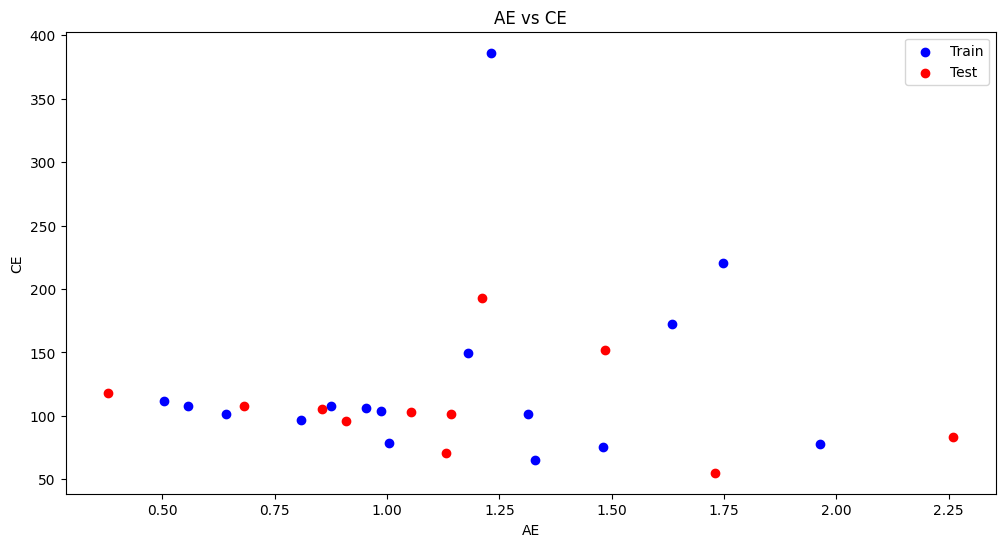

In [ ]:
train,test=split_data()

In [ ]:
si=np.load('/media/Blue2TB1/Jin_22/video_data/video_1/video_SI.npy')

FileNotFoundError: [Errno 2] No such file or directory: '/media/Blue2TB1/Jin_22/video_data/video_1/video_SI.npy'

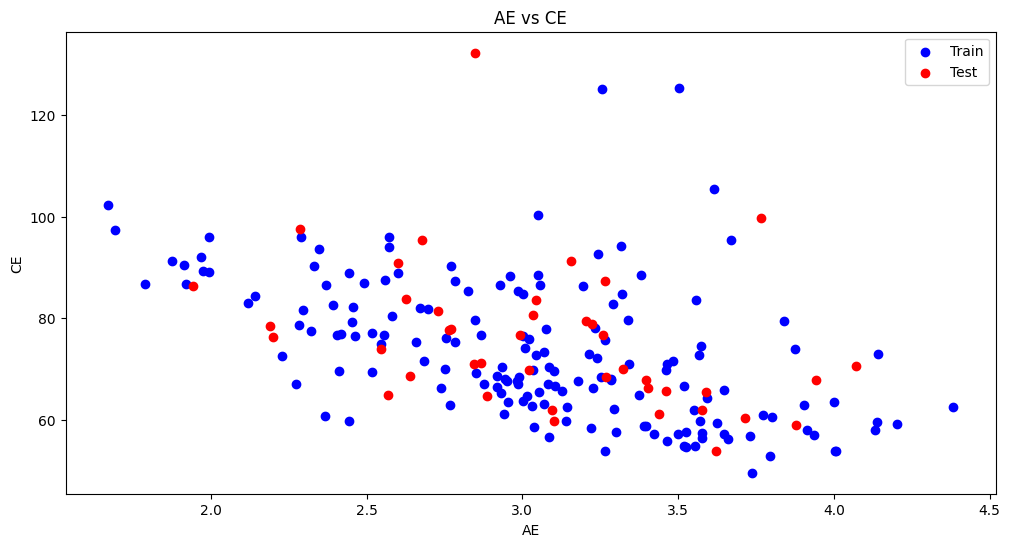

In [ ]:
dataset_dir='D:/CVPR18'
train,test=split_data(dataset_dir)

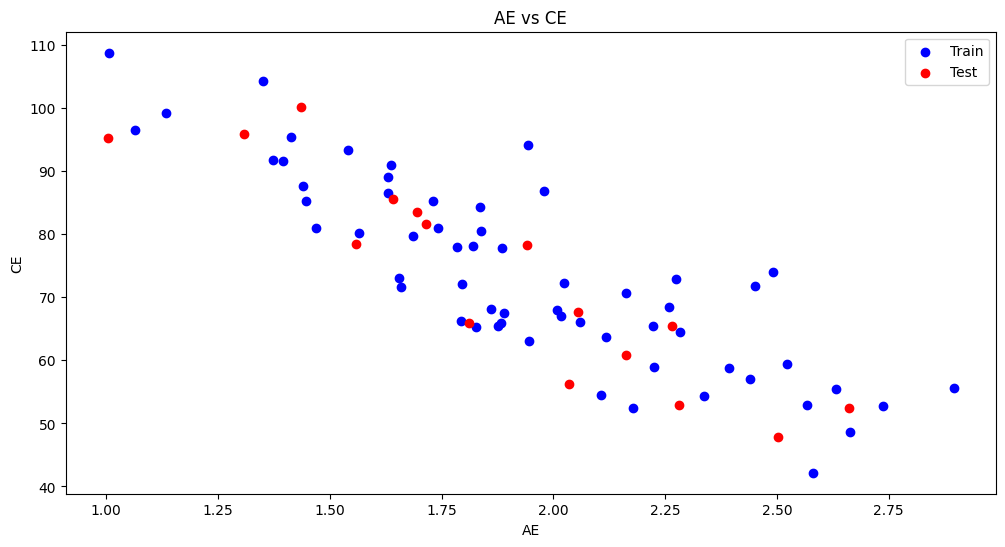

In [ ]:
dataset_dir='D:/PAMI18'
train,test=split_data(dataset_dir)